In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd
import pickle

%matplotlib inline 

## Open files and read in inputs for dataset popularity

## These files contain all datasets that have been accessed in a given week 

- point 1. of google doc

https://docs.google.com/document/d/1G-Z2jDxHHz7b9xaOSx50cgiv72zZEBVA_QsqeU-c5Rg/edit

- Open weekly file with accessed datasets
- df_1w is a panda dataframe

https://pandas.pydata.org/pandas-docs/stable/10min.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [2]:
filename = 'DataPopularity_ML/simpleModel_start_2017-02-17_meas_7_pred_7'

df_1w = pd.read_hdf(filename+'.h5', 'X')

display(df_1w.shape)

(30321, 14)

In [3]:
#check what it looks like
display(df_1w.head(5)) 

,name,scope,user,taskid,cputime,pandaid,size,nfiles,site,walltime,nevents,dsid,ptag,type
0,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,2,2,521,22,140932680,364,4,6201,772,266904,2950,DAOD_EGAM1
1,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,4,5,4125,226,157285182,226,7,45990,5822,266904,2950,DAOD_EXOT17
2,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,1,1,424,15,446525578,71,1,3188,0,266904,2880,DAOD_HIGG2D1
3,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,1,1,475,11,593515038,74,1,8940,20192,266904,2950,DAOD_HIGG4D3
4,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,2,2,265,11,63051094,113,2,2992,2720,266904,2950,DAOD_HIGG4D5


In [4]:
#Explore the data
display(df_1w.columns)
display(df_1w.dtypes)
display(df_1w.values)

Index(['name', 'scope', 'user', 'taskid', 'cputime', 'pandaid', 'size',
       'nfiles', 'site', 'walltime', 'nevents', 'dsid', 'ptag', 'type'],
      dtype='object')

name        object
scope       object
user         int64
taskid       int64
cputime      int64
pandaid      int64
size         int64
nfiles       int64
site         int64
walltime     int64
nevents      int64
dsid         int64
ptag         int64
type        object
dtype: object

array([[ 'data15_13TeV.00266904.physics_Main.merge.DAOD_EGAM1.r7600_p2521_p2950_tid10322338_00',
        'data15_13TeV', 2, ..., 266904, 2950, 'DAOD_EGAM1'],
       [ 'data15_13TeV.00266904.physics_Main.merge.DAOD_EXOT17.r7600_p2521_p2950_tid10324876_00',
        'data15_13TeV', 4, ..., 266904, 2950, 'DAOD_EXOT17'],
       [ 'data15_13TeV.00266904.physics_Main.merge.DAOD_HIGG2D1.r7600_p2521_p2880_tid09980951_00',
        'data15_13TeV', 1, ..., 266904, 2880, 'DAOD_HIGG2D1'],
       ..., 
       [ 'mc15_14TeV.167766.Sherpa_CT10_WmunuMassiveCBPt70_140_CJetVetoBVeto.merge.DAOD_TRUTH3.e2357_p2768_tid10165442_00',
        'mc15_14TeV', 1, ..., 167766, 2768, 'DAOD_TRUTH3'],
       [ 'mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_JETM3.e3601_s2997_r8903_r8906_p2996_tid10778681_00',
        'mc16_13TeV', 1, ..., 361106, 2996, 'DAOD_JETM3'],
       [ 'mc16_13TeV.410000.PowhegPythiaEvtGen_P2012_ttbar_hdamp172p5_nonallhad.merge.DAOD_JETM3.e3698_s2997_r8903_r8906_p2996_tid10778

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe056fc1860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe05707aeb8>]], dtype=object)

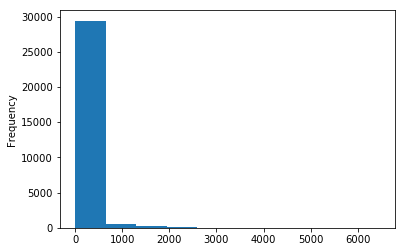

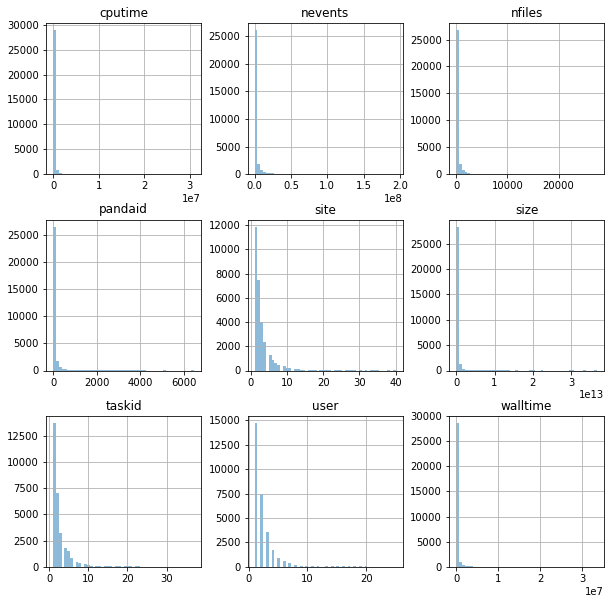

In [5]:
#make some plots
plt.figure();
df_1w.pandaid.plot.hist()

plt.figure()
df_1w[['user', 'taskid', 'cputime', 'pandaid', 'size', 
    'nfiles', 'site', 'walltime', 'nevents']].hist(alpha=0.5, bins=50, figsize=(10, 10))

## Example: open another week of data and merge with first one

In [107]:
#merge dataframes used for popularity measurement (used for inputs) -> gets the integral of distributions

def mergeDF(df, df_new):
    #print('Before')
    #display(df.shape)
    concatenated = pd.concat([df, df_new]) 
    #print('After')
    
    #drop date, sum over pandaids, sites, users, ...
    result = concatenated.groupby(['name','scope','dsid','ptag','type']).agg({"pandaid": np.sum, "user": np.sum,  "site": np.sum,
        "taskid": pd.Series.sum, "cputime": pd.Series.sum, "walltime": pd.Series.sum, "nevents": pd.Series.sum, 
        "nfiles": pd.Series.sum, "size": pd.Series.sum   # sum over unique pandaids, taskids, sites, users. Get the total/day for all the rest  
    }).reset_index()
  
    #display(df_new.shape)
    #display(result.shape)
    
    return result

In [108]:
filename = 'DataPopularity_ML/simpleModel_start_2017-02-24_meas_7_pred_7'

df_2w = pd.read_hdf(filename+'.h5', 'X')
display(df_2w.shape)

df_merged = mergeDF(df_1w, df_2w)
display(df_merged.shape)
display(df_merged.head(5)) 

(31266, 14)

(43958, 14)

,name,scope,dsid,ptag,type,site,taskid,nevents,user,cputime,nfiles,pandaid,walltime,size
0,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,266904,2950,DAOD_EGAM1,4,2,772,2,521,364,22,6201,140932680
1,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,266904,2950,DAOD_EXOT17,9,9,11644,6,7601,452,452,94111,314570364
2,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,266904,2880,DAOD_HIGG2D1,2,2,0,2,863,142,30,6574,893051156
3,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,266904,2950,DAOD_HIGG4D2,2,2,16504,2,277,102,2,985,420557136
4,data15_13TeV.00266904.physics_Main.merge.DAOD_...,data15_13TeV,266904,2950,DAOD_HIGG4D3,2,2,40384,2,795,148,12,9643,1187030076


## These files contain all datasets that have been created from 1.1.2016 to 25.7.2017


## Unzip files --> do only once!

In [109]:
import os
import tarfile
import zipfile

path = 'daod_datasets_2016_2017.tar.gz'
path = 'deleted_daod_datasets_2016_2017.tar.gz'

opener, mode = tarfile.open, 'r:gz'

cwd = os.getcwd()
os.chdir('DataPopularity_ML/')

try:
    file = opener(path, mode)
    try: file.extractall()
    finally: file.close()
finally:
    os.chdir(cwd)

## Define useful functions to manipulate dataset names

In [110]:
# get DSID from dataset name (as a int)
def getDSID(name):

    sub = name.split('.')
    #print(sub)

    dsid = sub[1]
    
    #remove 00 for data
    if (dsid.startswith('00')):
        dsid  = dsid[2:]
    #print(dsid)
    return(int(dsid))  

In [111]:
# get scope from dataset name
def getScope(name):

    sub = name.split('.')
    #print(sub)
    scope = sub[0]
    return(scope)  

In [112]:
# get ptag from dataset name (as a int)
def getPtag(name):

    sub = name.split('.')
    #print(sub)
    last = len(sub)
    tags = sub[last-1]
    #print(tags)
    ptag=0
    subtags = tags.split('_')
    #print(subtags)
    for i in subtags:
        if (i.startswith('p')): # takes always the last one
            ptag = int(i[1:])
            #print(i)
    return(ptag)      

In [113]:
# get Type from dataset name (DOAD_*)
def getType(name):

    sub = name.split('.')
    #print(sub)

    dstype = name
    for i in sub:
        if (i.startswith('DAOD_')): # takes always the last one
            dstype = i
    #print(dstype)
    return(dstype) 

## Datasets created from 1.1.2016 and not deleted (on 25/7/2017)

- point 2. of google doc
- format is scope, name, creation date and last access date (it’s 0 if never accessed). Date is in epoch second

In [160]:
df_not = pd.read_csv('DataPopularity_ML/daod_datasets_2016_2017.csv', header = None, sep = '\t',
                     names = ['scope', 'name', 'creation', 'lastaccess'])
display(df_not.head(5))

#drop useless columns
df_not = df_not.drop('lastaccess', axis =1)

#dataset manipulation: convert date in epoch to readable datedate (remove time in hours, leave only dates)
df_not['creation'] = df_not['creation'].apply(lambda x: datetime.datetime.fromtimestamp(int(x)).date())

#scope==archive are datasets on LOCALGROUPDSIK but not on DATADISK. Does not matter, let's replace with "real" scope 
df_not['scope'] = df_not['name'].apply(getScope)

# get a few others attributes
df_not['type'] = df_not['name'].apply(getType)
df_not['dsid'] = df_not['name'].apply(getDSID)
df_not['ptag'] = df_not['name'].apply(getPtag)

display(df_not.head(5))

,scope,name,creation,lastaccess
0,archive,data15_13TeV.00266904.physics_Main.merge.DAOD_...,1492789760,0
1,archive,data15_13TeV.00266919.physics_Main.merge.DAOD_...,1492789743,0
2,archive,data15_13TeV.00267073.physics_Main.merge.DAOD_...,1492789791,0
3,archive,data15_13TeV.00267152.physics_Main.merge.DAOD_...,1492789562,0
4,archive,data15_13TeV.00267162.physics_Main.merge.DAOD_...,1492789576,0


,scope,name,creation,type,dsid,ptag
0,data15_13TeV,data15_13TeV.00266904.physics_Main.merge.DAOD_...,2017-04-21,DAOD_EXOT15,266904,2614
1,data15_13TeV,data15_13TeV.00266919.physics_Main.merge.DAOD_...,2017-04-21,DAOD_EXOT15,266919,2614
2,data15_13TeV,data15_13TeV.00267073.physics_Main.merge.DAOD_...,2017-04-21,DAOD_EXOT15,267073,2614
3,data15_13TeV,data15_13TeV.00267152.physics_Main.merge.DAOD_...,2017-04-21,DAOD_EXOT15,267152,2614
4,data15_13TeV,data15_13TeV.00267162.physics_Main.merge.DAOD_...,2017-04-21,DAOD_EXOT15,267162,2614


## Datasets created from 1.1.2016 and already deleted (on 25/7/2017)

- point 3 of googledoc
- scope, name, creation date, deletion date, last access date (in ISO format)

In [162]:
df_del = pd.read_csv('DataPopularity_ML/deleted_daod_datasets_2016_2017.csv', header = None, sep = '\t',
                     names = ['scope', 'name', 'creation', 'deletion', 'lastaccess'])
display(df_del.head(5))

#drop useless columns
df_del = df_del.drop('lastaccess', axis =1)
df_del = df_del.drop('deletion', axis =1)

#dataset manipulation: remove time in hours, leave only dates
df_del['creation'] = df_del['creation'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").date())

#scope==archive are datasets on LOCALGROUPDSIK but not on DATADISK. Does not matter, let's replace with "real" scope 
df_del['scope'] = df_del['name'].apply(getScope)

# get a few others attributes
df_del['type'] = df_del['name'].apply(getType)
df_del['dsid'] = df_del['name'].apply(getDSID)
df_del['ptag'] = df_del['name'].apply(getPtag)

display(df_del.head(5))

,scope,name,creation,deletion,lastaccess
0,mc12_14TeV,mc12_14TeV.167792.Sherpa_CT10_WmunuMassiveCBPt...,2016-06-02T16:02:59Z,2016-06-07T08:12:26Z,NaN
1,mc12_14TeV,mc12_14TeV.167790.Sherpa_CT10_WenuMassiveCBPt5...,2016-06-02T15:58:59Z,2016-06-07T08:12:54Z,NaN
2,mc12_14TeV,mc12_14TeV.161963.Sherpa_CT10_llnunu_ZZ.merge....,2016-05-15T22:37:50Z,2016-05-23T13:48:02Z,NaN
3,mc12_14TeV,mc12_14TeV.167771.Sherpa_CT10_WenuMassiveCBPt1...,2016-06-02T15:45:18Z,2016-06-06T08:31:23Z,NaN
4,mc12_14TeV,mc12_14TeV.167779.Sherpa_CT10_WenuMassiveCBPt2...,2016-06-02T15:51:35Z,2016-06-06T08:31:23Z,NaN


,scope,name,creation,type,dsid,ptag
0,mc12_14TeV,mc12_14TeV.167792.Sherpa_CT10_WmunuMassiveCBPt...,2016-06-02,DAOD_TRUTH1,167792,2613
1,mc12_14TeV,mc12_14TeV.167790.Sherpa_CT10_WenuMassiveCBPt5...,2016-06-02,DAOD_TRUTH1,167790,2613
2,mc12_14TeV,mc12_14TeV.161963.Sherpa_CT10_llnunu_ZZ.merge....,2016-05-15,DAOD_TRUTH1,161963,2613
3,mc12_14TeV,mc12_14TeV.167771.Sherpa_CT10_WenuMassiveCBPt1...,2016-06-02,DAOD_TRUTH1,167771,2613
4,mc12_14TeV,mc12_14TeV.167779.Sherpa_CT10_WenuMassiveCBPt2...,2016-06-02,DAOD_TRUTH1,167779,2613


In [161]:
# now merge them
display(df_del.shape)
display(df_not.shape)

concatenated = pd.concat([df_del, df_not])
display(concatenated.shape)
df_all = concatenated.drop_duplicates()
display(df_all.shape)

# There can still be duplicates based on name only in case one dataset was archived. 
# In this case the dataset name is the same, but creation date is different

(229038, 6)

(271123, 6)

(500161, 6)

(499938, 6)

## now df_all contains all datasets created from 1/1/2016 to 25/7/2017

- format is scope, name, creation date, type, dsid, ptag